In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import pickle

In [9]:
train_img_dir = "/Users/jalalsmac/CVPR/Final/Massachusetts urban building/png/train"
train_mask_dir = "/Users/jalalsmac/CVPR/Final/Massachusetts urban building/png/train_labels"
val_img_dir = "/Users/jalalsmac/CVPR/Final/Massachusetts urban building/png/val"
val_mask_dir = "/Users/jalalsmac/CVPR/Final/Massachusetts urban building/png/val_labels"
test_img_dir = "/Users/jalalsmac/CVPR/Final/Massachusetts urban building/png/test"
test_mask_dir = "/Users/jalalsmac/CVPR/Final/Massachusetts urban building/png/test_labels"


In [11]:
train_images = []
train_masks = []
val_images = []
val_masks = []
test_images = []
test_masks = []

In [13]:
train_image_filenames = sorted(os.listdir(train_img_dir))  
train_mask_filenames = sorted(os.listdir(train_mask_dir))


In [15]:
val_image_filenames = sorted(os.listdir(val_img_dir))  
val_mask_filenames = sorted(os.listdir(val_mask_dir))


In [17]:
test_image_filenames = sorted(os.listdir(test_img_dir))  
test_mask_filenames = sorted(os.listdir(test_mask_dir))


In [19]:
for  train_img_file, train_mask_file in zip(train_image_filenames, train_mask_filenames):
    try:
    
        img_path = os.path.join(train_img_dir, train_img_file)
        mask_path = os.path.join(train_mask_dir, train_mask_file)

        img = load_img(img_path, target_size=(256, 256)) 
        mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")  

        #normalize my images
        img = img_to_array(img) / 255.0  
        mask = img_to_array(mask).astype(np.uint8) / 255.0

        train_images.append(img)
        train_masks.append(mask)

    except Exception as e:
        print(f"Error loading {train_img_file} or {train_mask_file}: {e}")

In [20]:
train_images=np.array(train_images)
train_masks=np.array(train_masks)

In [21]:
train_images.shape

(137, 256, 256, 3)

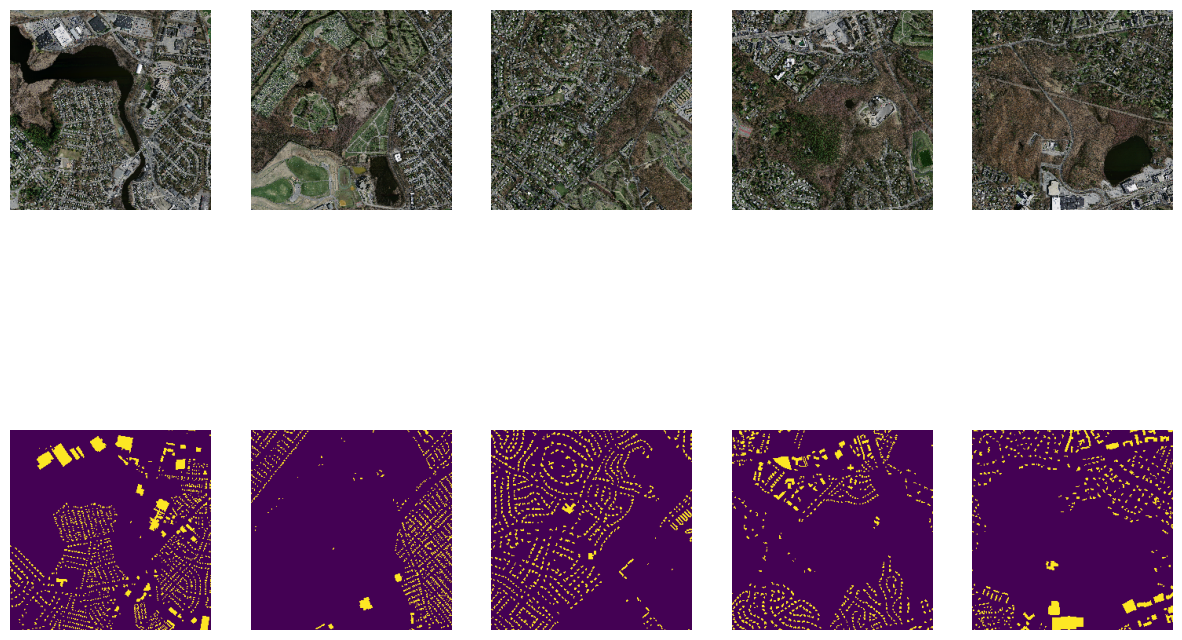

In [25]:
i=0
plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(train_images[i])
    plt.axis('off')
    plt.subplot(2,5,i+6)
    plt.imshow(train_masks[i])
    plt.axis('off')
plt.show()

In [27]:
for val_img_file, val_mask_file in zip(val_image_filenames, val_mask_filenames):
    try:
        img_path = os.path.join(val_img_dir, val_img_file)
        mask_path = os.path.join(val_mask_dir, val_mask_file)

        img = load_img(img_path, target_size=(256, 256))  
        mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale") 

        img = img_to_array(img) / 255.0  
        mask = img_to_array(mask).astype(np.uint8) / 255.0

        val_images.append(img)
        val_masks.append(mask)

    except Exception as e:
        print(f"Error loading {val_img_file} or {val_mask_file}: {e}")

In [29]:
val_images=np.array(val_images)
val_masks=np.array(val_masks)

In [31]:
for  test_img_file, test_mask_file in zip(test_image_filenames, test_mask_filenames):
    try:
    
        img_path = os.path.join(test_img_dir, test_img_file)
        mask_path = os.path.join(test_mask_dir, test_mask_file)

        img = load_img(img_path, target_size=(256, 256)) 
        mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")  

        #normalize
        img = img_to_array(img) / 255.0  
        mask = img_to_array(mask).astype(np.uint8) / 255.0

        test_images.append(img)
        test_masks.append(mask)

    except Exception as e:
        print(f"Error loading {test_img_file} or {test_mask_file}: {e}")

In [32]:
test_images=np.array(test_images)
test_masks=np.array(test_masks)

In [35]:
test_images.shape

(10, 256, 256, 3)

In [37]:
from tensorflow.keras import layers, Model

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [41]:
def compute_miou(y_true, y_pred, num_classes=2):
    
    y_pred = (y_pred > 0.21).astype(np.uint8)  
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union + 1e-7)  
    return iou_score

In [43]:
def compute_precision(y_true, y_pred):
    y_pred = (y_pred > 0.21).astype(np.uint8)
    return precision_score(y_true.flatten(), y_pred.flatten())

In [45]:
def compute_f1(y_true, y_pred):
    y_pred = (y_pred > 0.21).astype(np.uint8)
    return f1_score(y_true.flatten(), y_pred.flatten())

In [47]:
def compute_mean_pixel_accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.21).astype(np.uint8)
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size
    return correct_pixels / total_pixels

In [49]:
def compute_fwiou(y_true, y_pred, num_classes=2):
    y_pred = (y_pred > 0.21).astype(np.uint8)
    iou_scores = []
    total_pixels = y_true.size
    for c in range(num_classes):
        class_mask = (y_true == c)
        intersection = np.sum(np.logical_and(class_mask, (y_pred == c)))
        union = np.sum(np.logical_or(class_mask, (y_pred == c)))
        class_ratio = np.sum(class_mask) / total_pixels
        iou_scores.append(class_ratio * (intersection / (union + 1e-7)))
    return np.sum(iou_scores)

In [51]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.keras.activations.sigmoid(y_pred)

    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - (numerator / (denominator + tf.keras.backend.epsilon()))

In [53]:
def combined_loss(y_true, y_pred):
    dice_weight = 0.7  
    bce_weight = 0.3   
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return dice_weight * dice + bce_weight * bce

In [55]:
def identity_block(X, filters):
    f1, f2, f3 = filters
    X_copy = X

    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=1, padding="valid")(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)

    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=3, padding="same")(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)

    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=1, padding="valid")(X)
    X = layers.BatchNormalization()(X)

    # Skip Connection
    X = layers.Add()([X, X_copy])
    X = layers.ReLU()(X)

    return X


In [57]:
def conv_block(X, filters, s=2):
    f1, f2, f3 = filters
    X_copy = X

    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=1, strides=s, padding="valid")(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)

    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=3, padding="same")(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)

    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=1, padding="valid")(X)
    X = layers.BatchNormalization()(X)

    # Adjust Skip Connection Dimensions
    X_copy = layers.Conv2D(filters=f3, kernel_size=1, strides=s, padding="valid")(X_copy)
    X_copy = layers.BatchNormalization()(X_copy)

    # Skip Connection
    X = layers.Add()([X, X_copy])
    X = layers.ReLU()(X)

    return X

In [59]:
def resnet50_encoder(input_shape):
    X_input = layers.Input(input_shape)

    # Initial Conv Layer
    X = layers.ZeroPadding2D((3, 3))(X_input)
    X = layers.Conv2D(64, (7, 7), strides=2)(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)
    X = layers.MaxPooling2D((3, 3), strides=2)(X)

    # ResNet Stages (with Skip Connections)
    enc1 = conv_block(X, filters=[64, 64, 256], s=1) #Here we got 64,64,64 X shape, now what i will do i will call conv_block..because in skip connection
                                                     #we need to balance the feature map...
    enc1 = identity_block(enc1, filters=[64, 64, 256])#completed again final size is 64,64,256
    enc1 = identity_block(enc1, filters=[64, 64, 256])#again 64,64,256

    enc2 = conv_block(enc1, filters=[128, 128, 512], s=2) #after succefully complete this, size become 32,32,512
    enc2 = identity_block(enc2, filters=[128, 128, 512])#completed ,and final size is 32,32,512
    enc2 = identity_block(enc2, filters=[128, 128, 512])
    enc2 = identity_block(enc2, filters=[128, 128, 512])#final size become 32,32,512

    enc3 = conv_block(enc2, filters=[256, 256, 1024], s=2) #completed and size is 16,16,1024
    enc3 = identity_block(enc3, filters=[256, 256, 1024])#completed..
    enc3 = identity_block(enc3, filters=[256, 256, 1024])
    enc3 = identity_block(enc3, filters=[256, 256, 1024])
    enc3 = identity_block(enc3, filters=[256, 256, 1024])
    enc3 = identity_block(enc3, filters=[256, 256, 1024])#completed and final shape is 16,16,1024

    enc4 = conv_block(enc3, filters=[512, 512, 2048], s=2)#completed and shape become 8,8,2048
    enc4 = identity_block(enc4, filters=[512, 512, 2048])
    enc4 = identity_block(enc4, filters=[512, 512, 2048])#final shape is 8,8,2048..so tough

    # Bottleneck (8x8)
    bottleneck = layers.Conv2D(2048, kernel_size=3, padding="same", activation="relu")(enc4)#this part is interesting..we again put the input into
                                                                                            #convolutional operation and size remain same 
                                                                                            # 8,8,2024

    return Model(inputs=X_input, outputs=[bottleneck, enc4, enc3, enc2, enc1])#so now for my decoder part, and i need to use attention module,
                                                                              #i need enc1,enc2,enc3,enc4 and bottlenect

In [61]:
def channel_attention(x, ratio=8):
    channel = x.shape[-1]  

    shared_layer_one = layers.Dense(channel // ratio, activation='relu')
    shared_layer_two = layers.Dense(channel, activation='sigmoid')

    avg_pool = layers.GlobalAveragePooling2D()(x)
    max_pool = layers.GlobalMaxPooling2D()(x)

    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    scale = layers.Add()([avg_pool, max_pool])
    scale = layers.Reshape((1, 1, channel))(scale)
    return layers.Multiply()([x, scale])

In [63]:
def spatial_attention(x):
    avg_pool = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(x)
    max_pool = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(x)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    scale = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    return layers.Multiply()([x, scale])

In [65]:
def cbam(x):
    x = channel_attention(x)
    x = spatial_attention(x)
    return x

In [67]:
def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding="same")(x)
    target_size = (tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2])
    skip = layers.Resizing(target_size[0], target_size[1])(skip)
    skip = cbam(skip)  
    x = layers.Concatenate()([x, skip])  
    x = layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu")(x)
    return x

In [69]:
def unet_with_cbam(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    resnet_encoder = resnet50_encoder(input_shape)  
    bottleneck, enc4, enc3, enc2, enc1 = resnet_encoder(inputs)
    x = decoder_block(bottleneck, enc4, 1024)
    x = decoder_block(x, enc3, 512)
    x = decoder_block(x, enc2, 256)
    x = decoder_block(x, enc1, 128)
    x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding="same")(x)
    x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(num_classes, kernel_size=1, activation="sigmoid")(x)
    return Model(inputs, outputs)

In [71]:
model = unet_with_cbam(input_shape=(256, 256, 3), num_classes=1)

In [73]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 8, 8,     │ 61,338,496 │ input_layer[0][0] │
│ (Functional)        │ 2048), (None, 8,  │            │                   │
│                     │ 8, 2048), (None,  │            │                   │
│                     │ 16, 16, 1024),    │            │                   │
│                     │ (None, 32, 32,    │            │                   │
│                     │ 512), (None, 63,  │            │                   │
│                     │ 63, 256)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 16, 16,    │          0 │ functional[0][1]  │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resizing[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resizing[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2048)      │    526,336 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 2048)      │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 32, 32,    │          0 │ functional[0][2]  │
│ (Resizing)          │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ add_16[0][0]      │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ resizing_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ resizing_1[0][0]  │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 16, 16,    │          0 │ resizing[0][0],   │
│                     │ 2048)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    131,200 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 16, 16, 1) │    100,353 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 124,500,853 (474.93 MB)

 Trainable params: 124,447,733 (474.73 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [75]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=combined_loss,  
    metrics=['accuracy']
)



In [77]:

EPOCHS=20 
BATCH_SIZE =4


In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [81]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),  
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, verbose=1, min_lr=0.0000001)
]

In [83]:
history = model.fit(
    train_images, train_masks,
    validation_data=(test_images, test_masks),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 490s 14s/step - accuracy: 0.8448 - loss: 0.6989 - val_accuracy: 0.8137 - val_loss: 0.6718 - learning_rate: 1.0000e-04
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 526s 15s/step - accuracy: 0.8676 - loss: 0.6549 - val_accuracy: 0.8137 - val_loss: 0.6498 - learning_rate: 1.0000e-04
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 501s 14s/step - accuracy: 0.8679 - loss: 0.6570 - val_accuracy: 0.8137 - val_loss: 0.6599 - learning_rate: 1.0000e-04
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 547s 16s/step - accuracy: 0.8795 - loss: 0.6588 - val_accuracy: 0.8137 - val_loss: 0.6855 - learning_rate: 1.0000e-04
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 553s 16s/step - accuracy: 0.8606 - loss: 0.6480 - val_accuracy: 0.8137 - val_loss: 0.6828 - learning_rate: 1.0000e-04
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 545s 16s/step - accuracy: 0.8689 - loss: 0.6516 - val_accuracy: 0.8137 - val_loss: 0.7430 - learning_rate: 1.0000e-04
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 545s 16s/step - accuracy: 

In [89]:
predictions = model.predict(val_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


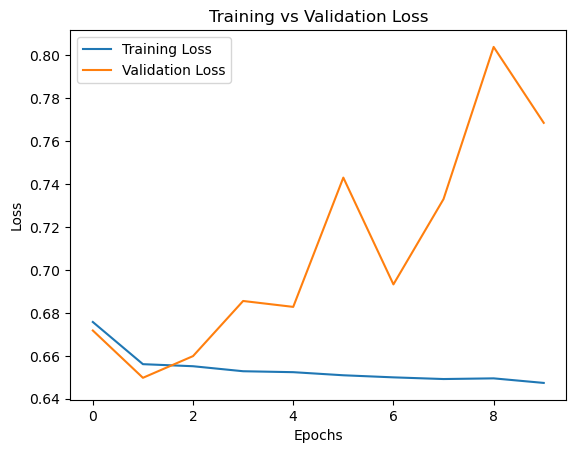

In [90]:


plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


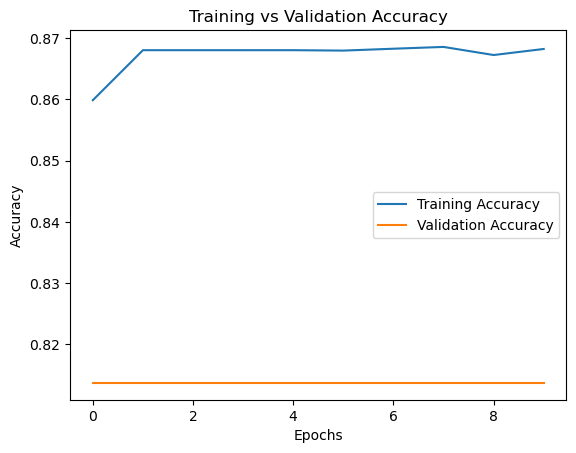

In [93]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [95]:
best_epoch = np.argmin(history.history["val_loss"]) + 1 
best_val_loss = min(history.history["val_loss"])
best_val_accuracy = max(history.history["val_accuracy"])

print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")


Best Epoch: 2
Best Validation Loss: 0.6498
Best Validation Accuracy: 0.8137


In [97]:

flat_predictions = predictions.flatten()

print(f"Min: {np.min(flat_predictions)}, Max: {np.max(flat_predictions)}")
print(f"Mean: {np.mean(flat_predictions)}, Std Dev: {np.std(flat_predictions)}")


Min: 0.1516590416431427, Max: 0.45777228474617004
Mean: 0.19968464970588684, Std Dev: 0.0324665792286396


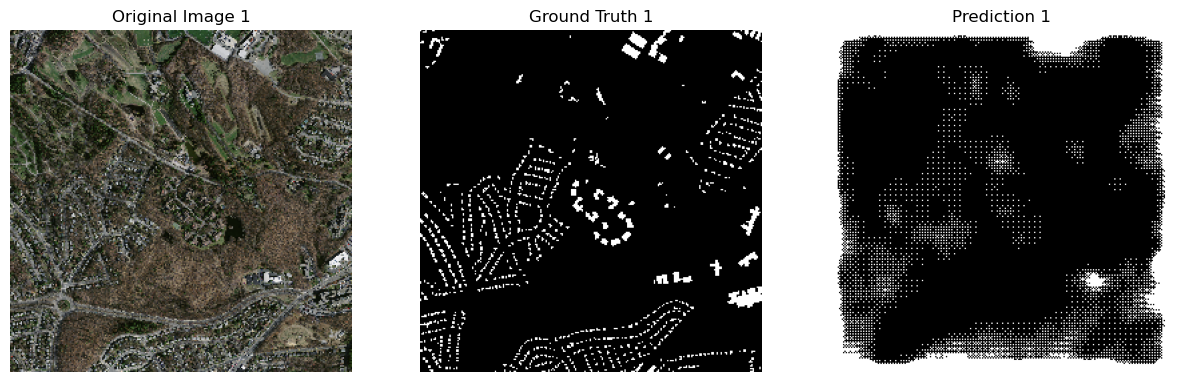

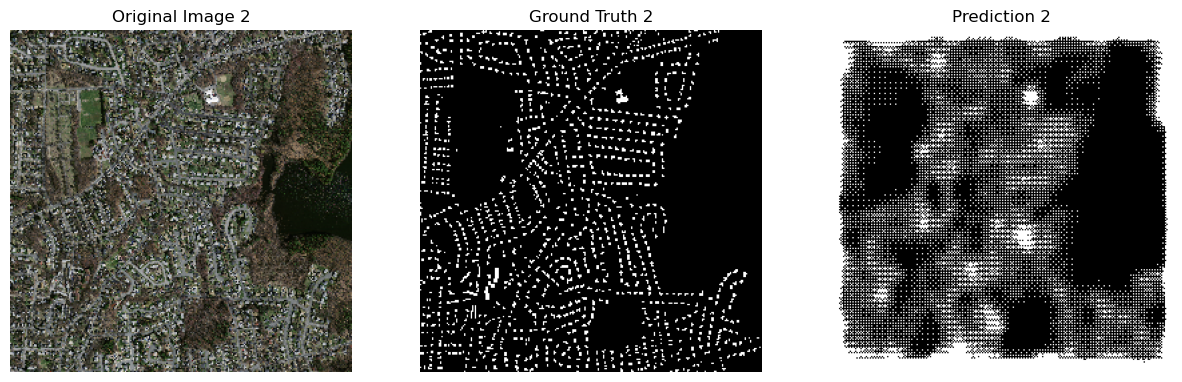

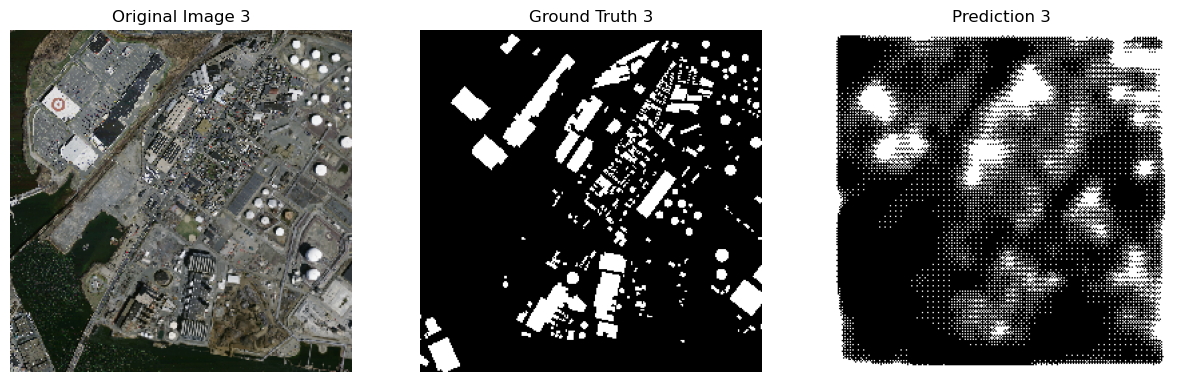

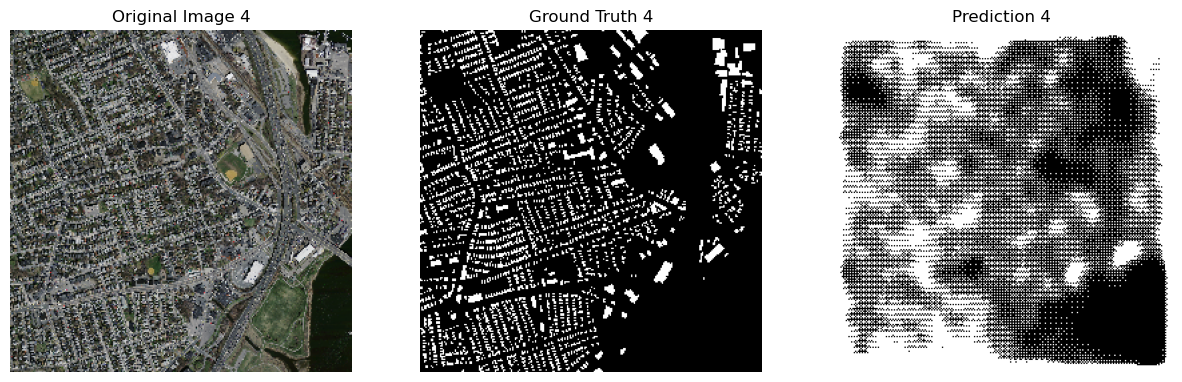

In [113]:

num_images = len(val_images)  

for i in range(num_images):
    original_image = val_images[i]
    ground_truth_mask = val_masks[i]
    predicted_mask = predictions[i] > 0.20  

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Prediction {i+1}")
    plt.axis('off')
    
    plt.show()


In [101]:
miou = compute_miou(val_masks, predictions)
precision = compute_precision(val_masks, predictions)
f1 = compute_f1(val_masks, predictions)
mpa = compute_mean_pixel_accuracy(val_masks, predictions)
fwiou = compute_fwiou(val_masks, predictions)

In [103]:
print(f"MIoU: {miou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Pixel Accuracy: {mpa:.4f}")
print(f"Frequency Weighted IoU: {fwiou:.4f}")

MIoU: 0.0981
Precision: 0.1540
F1 Score: 0.1787
Mean Pixel Accuracy: 0.7874
Frequency Weighted IoU: 0.7080
